In [2]:
import pickle
import gc
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns

from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


In [3]:
months = ['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28', '2015-05-28',
         '2015-06-28', '2015-07-28', '2015-08-28', '2015-09-28', '2015-10-28',
         '2015-11-28', '2015-12-28', '2016-01-28', '2016-02-28', '2016-03-28',
         '2016-04-28', '2016-05-28'] # unique months whose data we have
       
products = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 
            'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 
            'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 
            'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 
            'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
            'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
            'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
            'ind_nomina_ult1', 'ind_nom_pens_ult1',  'ind_recibo_ult1'] # all possible products available to buy
        
rec_products = ['ind_recibo_ult1', 'ind_cco_fin_ult1', 'ind_nom_pens_ult1',
                'ind_nomina_ult1', 'ind_tjcr_fin_ult1', 'ind_ecue_fin_ult1',
                'ind_cno_fin_ult1', 'ind_ctma_fin_ult1', 'ind_reca_fin_ult1',
                'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_valo_fin_ult1'] # all products we hope to recommend
    
features = ['fecha_dato', 'ncodpers', 'ind_empleado', 
                'pais_residencia', 'sexo', 'age', 'fecha_alta', 'ind_nuevo', 
                'antiguedad', 'indrel', 'ult_fec_cli_1t', 'indrel_1mes',
                'tiprel_1mes', 'indresi', 'indext', 'conyuemp', 'canal_entrada',
                'indfall', 'tipodom', 'cod_prov', 'nomprov',
                'ind_actividad_cliente', 'renta', 'segmento'] # user features provided

In [4]:
data = pd.read_csv('drive/My Drive/santander-product-recommendation/train_ver2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
data.sexo = data.sexo.map(lambda x: x == 'M')
data.ind_empleado = data.ind_empleado.map(lambda x: 0 if (x=='N' or x=='S') else 1)

In [5]:
data.segmento.unique()

array(['02 - PARTICULARES', '03 - UNIVERSITARIO', nan, '01 - TOP'],
      dtype=object)

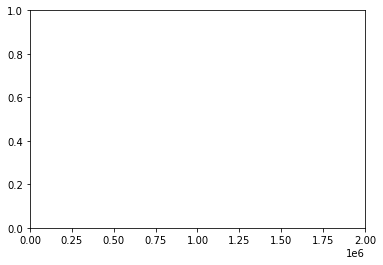

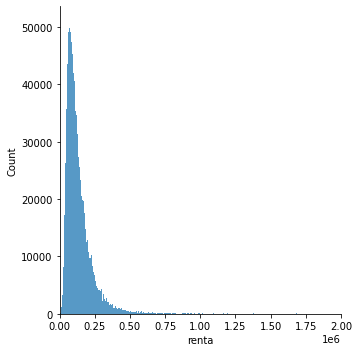

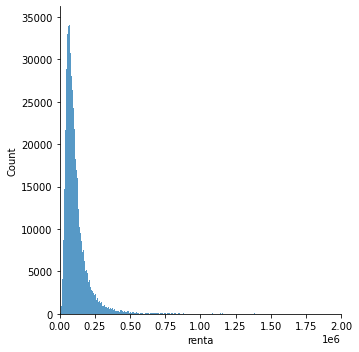

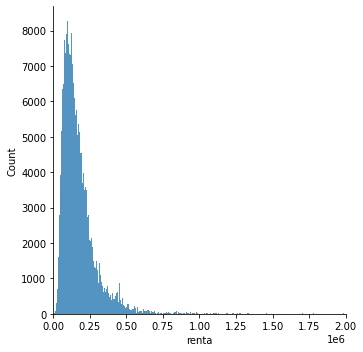

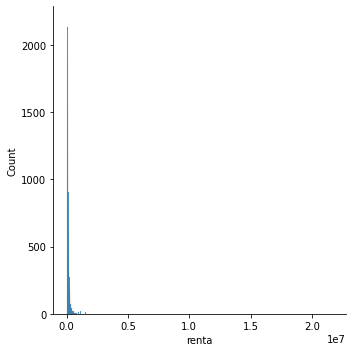

In [8]:
plt.xlim(0, 0.2e7)
adata = data[data.segmento == '02 - PARTICULARES']
sns.displot(adata['renta'])
del adata
plt.xlim(0, 0.2e7)
bdata = data[data.segmento == '03 - UNIVERSITARIO']
sns.displot(bdata['renta'])
del bdata
plt.xlim(0, 0.2e7)
cdata = data[data.segmento == '01 - TOP']
sns.displot(cdata['renta'])
del cdata
plt.xlim(0, 0.2e7)
ddata = data[data.segmento.isnull()]
sns.displot(ddata['renta'])
del ddata

These diagrams show that the rent distirbution for nan mirrors that for particulaires and hence I am inferring that we can treat them as the same. Furhtermore all the distributions are fairly distinct and show normal behaviour with very heavy tails. So the median might be a more stable estimator for rent given segment. We can use this to calculate imputed values.

## Missing Months
Clearly not all the data is provided with significant amounts of months missing and a large number of users having 11 months worth of data. 

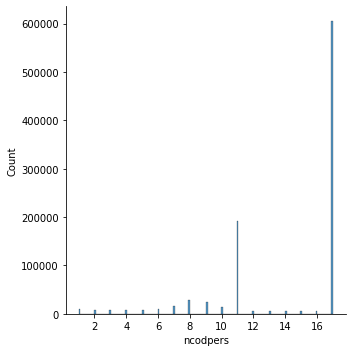

In [23]:
users_by_month = data.ncodpers.value_counts()
sns.displot(users_by_month)

There are quite a few missing values in general but similar numbers keep showing up like 27734. I believe if the product is null we can ignore since the bank shouldhave records for sales and null mostly could be missing data entry.

In [29]:
null_cols = data.isnull().sum()
null_cols[null_cols > 1000]

ind_empleado                27734
pais_residencia             27734
sexo                        27804
fecha_alta                  27734
ind_nuevo                   27734
indrel                      27734
ult_fec_cli_1t           13622516
indrel_1mes                149781
tiprel_1mes                149781
indresi                     27734
indext                      27734
conyuemp                 13645501
canal_entrada              186126
indfall                     27734
tipodom                     27735
cod_prov                    93591
nomprov                     93591
ind_actividad_cliente       27734
renta                     2794375
segmento                   189368
ind_nomina_ult1             16063
ind_nom_pens_ult1           16063
dtype: int64

Importantly there are a quite a few missing rent data points. We can naively find another field that is heavily correlated with it and use that field to extrapolate a value to impute.

In [44]:
data[features].corrwith(data.renta)

ncodpers                -0.084213
ind_nuevo               -0.014134
indrel                   0.000022
tipodom                       NaN
cod_prov                -0.015239
ind_actividad_cliente    0.027281
renta                    1.000000
dtype: float64

It seems like international country get ignored for region code and this can simply be imputed by adding new code. This takes care of the vast majority of cases of missing info te remaining can be their own unknown code.

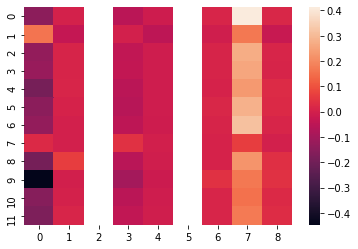

In [11]:
corrs = np.zeros([len(rec_products), 9])
for i, p in enumerate(rec_products):
    corrs[i] = data[features].corrwith(data[p])

sns.heatmap(corrs)